
Машинное обучение. Лабораторная работа №1-2.
Выполнила: Лейченко Кира Андреевна

Группа: М8О-308Б-18.

Вариант: 11


In [129]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix


from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import check_random_state
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import naive_bayes
from sklearn.svm import SVC
import time
import warnings
warnings.filterwarnings("ignore")
from collections import Counter
import sys


Данный датасет содержит информацию о красном  португальском вине "Vinho Verde". В данном датасете определяется качество вина по следующим признакам:
1 - фиксированная кислотность
2 - летучая кислотность
3 - лимонная кислота
4 - остаточный сахар
5 - хлориды
6 - свободный диоксид серы
7 - диоксид серы общий
8 - плотность
9 - pH
10 - сульфаты
11 - алкоголь.
Выходная переменная (на основе сенсорных данных):
12 - качество (оценка от 0 до 10)

**Импортируем данные**

In [4]:

data = pd.read_csv('/content/sample_data/winequality-red.csv')
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


**Размер датасета**

In [5]:
data.shape

(1599, 12)

**Найдем корреляцию**

In [6]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


Давайте посчитаем какой из признаков более всех влияет на качество вина

In [7]:
data.corr()['quality'].sort_values(ascending=False)

quality                 1.000000
alcohol                 0.476166
sulphates               0.251397
citric acid             0.226373
fixed acidity           0.124052
residual sugar          0.013732
free sulfur dioxide    -0.050656
pH                     -0.057731
chlorides              -0.128907
density                -0.174919
total sulfur dioxide   -0.185100
volatile acidity       -0.390558
Name: quality, dtype: float64

Как можно отсюда заметить, что ни один параметр парктически не влияет на качество вина.
Давайте построим диаграмму рассеяния для всех оставшихся признаков.


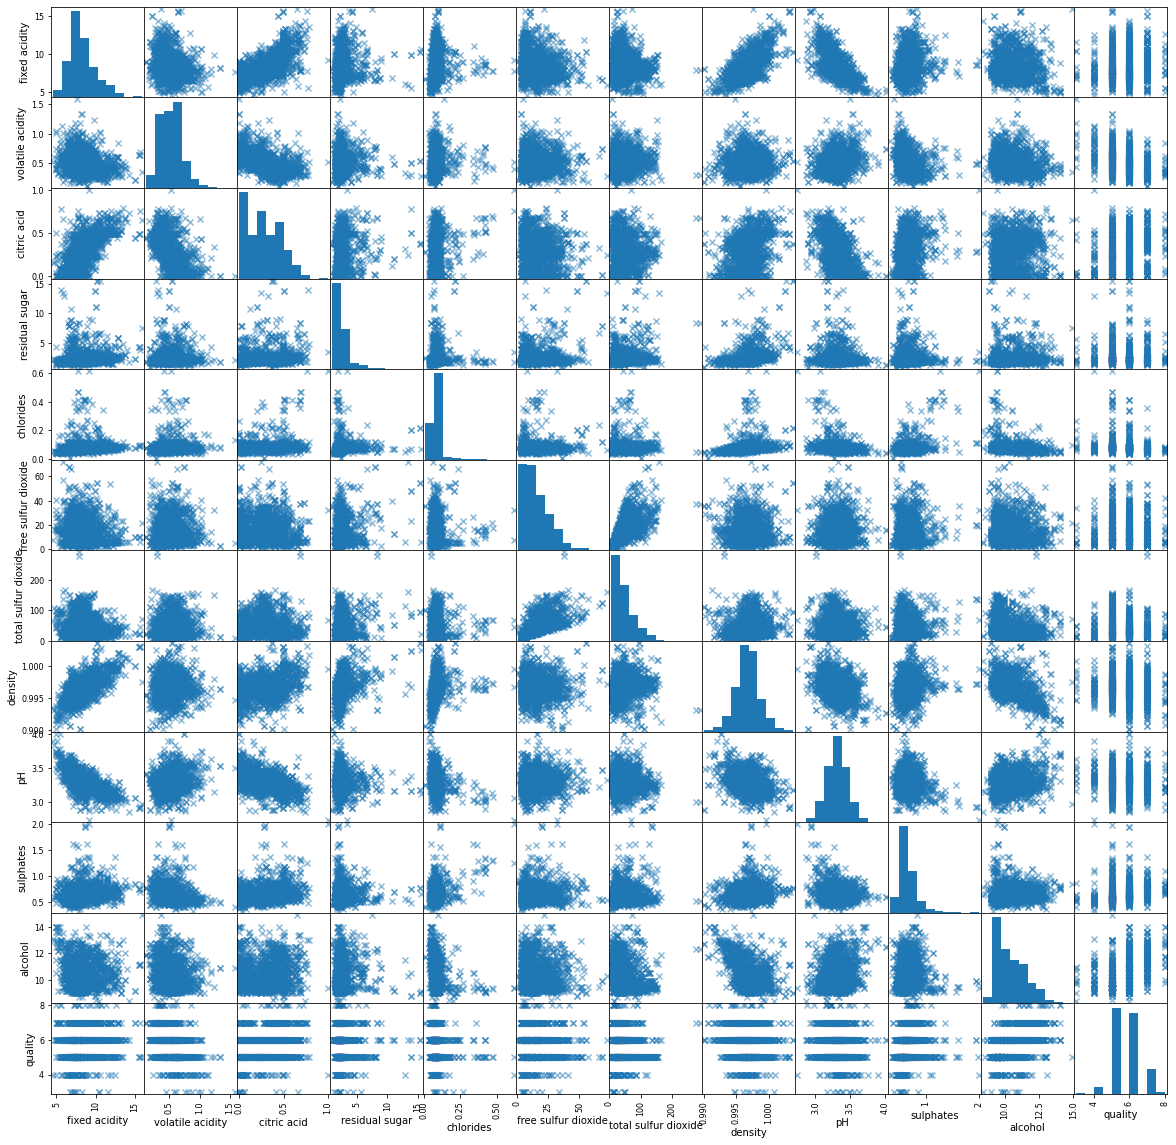

In [8]:
scatter_matrix(data, figsize=(20, 20), marker='x');

**Подготовка данных**

Давайте будем классифицировать не конкретную оценку вина, а его тип хорошее>5(1) и посредственное<= 5(0)

In [9]:
binary_mark=[]
for mark in data['quality']:
  if mark>5:
    binary_mark.append(1)
  else:
    binary_mark.append(0)


In [10]:
data_normalized = (data - data.mean()) / data.std()
data_normalized.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03
mean,-1.570643e-14,-1.590973e-15,6.045057e-15,-1.344696e-15,5.098590e-15,-7.724347e-17,1.619856e-16,4.946064e-13,-5.937923e-15,-2.175036e-15,2.580411e-14,1.081756e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.136377e+00,-2.277567e+00,-1.391037e+00,-1.162333e+00,-1.603443e+00,-1.422055e+00,-1.230199e+00,-3.537625e+00,-3.699244e+00,-1.935902e+00,-1.898325e+00,-3.264143e+00
25%,-7.004996e-01,-7.696903e-01,-9.290275e-01,-4.530767e-01,-3.711129e-01,-8.484502e-01,-7.438076e-01,-6.075656e-01,-6.549356e-01,-6.380200e-01,-8.661079e-01,-7.875763e-01
50%,-2.410190e-01,-4.367545e-02,-5.634264e-02,-2.402999e-01,-1.798892e-01,-1.792441e-01,-2.574163e-01,1.759533e-03,-7.210449e-03,-2.250577e-01,-2.092427e-01,4.507074e-01
75%,5.056370e-01,6.264921e-01,7.650078e-01,4.340257e-02,5.382858e-02,4.899619e-01,4.721707e-01,5.766445e-01,5.757422e-01,4.238832e-01,6.352984e-01,4.507074e-01
max,4.353787e+00,5.876138e+00,3.742403e+00,9.192806e+00,1.112355e+01,5.365606e+00,7.372847e+00,3.678904e+00,4.526866e+00,7.916200e+00,4.201138e+00,2.927275e+00


In [11]:
data_normalized['binary_mark']=binary_mark
data_normalized.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,binary_mark
0,-0.528194,0.961576,-1.391037,-0.453077,-0.243630,-0.466047,-0.379014,0.558100,1.288240,-0.579025,-0.959946,-0.787576,0
1,-0.298454,1.966827,-1.391037,0.043403,0.223805,0.872365,0.624168,0.028252,-0.719708,0.128910,-0.584594,-0.787576,0
2,-0.298454,1.296660,-1.185699,-0.169374,0.096323,-0.083643,0.228975,0.134222,-0.331073,-0.048074,-0.584594,-0.787576,0
3,1.654339,-1.384011,1.483689,-0.453077,-0.264878,0.107558,0.411372,0.664069,-0.978798,-0.461036,-0.584594,0.450707,1
4,-0.528194,0.961576,-1.391037,-0.453077,-0.243630,-0.466047,-0.379014,0.558100,1.288240,-0.579025,-0.959946,-0.787576,0


**Посчитаем количество элементов каждого типа качества**

In [13]:
quality_count={} 
for i in range(0,2):
  quality_count[i]=(data_normalized['binary_mark'] ==i).sum()
quality_count
dif_proc=abs((quality_count[0]/data.shape[0]-quality_count[1]/data.shape[0])*100)
dif_proc

6.941838649155718

Как можно видеть,что данный датасет сбалансированный по классам,так как разница в количестве< 10%


Заготавливаем функцию, которая будет отвечать за обучение, тестирование, подсчёт точности и др

In [14]:
def DisplayMetrics(Method, X, Y, folds = 5, average = 'macro'):
  kf = StratifiedKFold(n_splits = folds, random_state = 128, shuffle = True)
  precision = np.zeros(folds)   
  recall = np.zeros(folds)  
  testAc = np.zeros(folds)
  trainAc = np.zeros(folds)
  X=X.astype(np.float32)
  for step, (trainI, valI) in enumerate(kf.split(X, Y)):
    TrX, TrY = X.loc[trainI].to_numpy(), Y.loc[trainI].to_numpy()
    ValX, ValY = X.loc[valI].to_numpy(), Y.loc[valI].to_numpy()
    Method.fit(TrX, TrY)
    PredY = Method.predict(ValX)
    PredTrY = Method.predict(TrX)
    precision[step] = precision_score(ValY, PredY, average = average)
    recall[step] = recall_score(ValY, PredY, average = average)
    trainAc[step] = accuracy_score(TrY, PredTrY)
    testAc[step] = accuracy_score(ValY, PredY)
  print("precision:", precision.mean())
  print("recall:", recall.mean())
  print("train_accuracy:", trainAc.mean())
  print("test_accuracy:", testAc.mean())

##KNN

In [15]:
class KNN():
    def __init__(self, neighbors=5):
        self.nn = neighbors
        self.breakraiser = 0
    
    def fit(self, X, y):
        self.X = X
        self.y = y.reshape((y.shape[0], 1))

    def __get_distances(self, p):
        t = (self.X - p)
        return np.sqrt((t**2).sum(1))

    def predict(self, X):
        n = X.shape[0]
        y_pred = np.zeros(n)
        y_sorted = np.zeros(self.nn)
        countF=0
        for i in range(n):
            d = self.__get_distances(X[i])
            for it,val in enumerate(np.argpartition(d, self.nn)[:self.nn]):
                y_sorted[it]=self.y[val]
            y_pred[i] = Counter(y_sorted).most_common(1)[0][0]
        return y_pred

In [28]:
data_x=data_normalized.iloc[:,0:10]
data_x.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates
0,-0.528194,0.961576,-1.391037,-0.453077,-0.243630,-0.466047,-0.379014,0.558100,1.288240,-0.579025
1,-0.298454,1.966827,-1.391037,0.043403,0.223805,0.872365,0.624168,0.028252,-0.719708,0.128910
2,-0.298454,1.296660,-1.185699,-0.169374,0.096323,-0.083643,0.228975,0.134222,-0.331073,-0.048074
3,1.654339,-1.384011,1.483689,-0.453077,-0.264878,0.107558,0.411372,0.664069,-0.978798,-0.461036
4,-0.528194,0.961576,-1.391037,-0.453077,-0.243630,-0.466047,-0.379014,0.558100,1.288240,-0.579025


In [76]:
data_y=data_normalized['binary_mark']
data_y.shape[0]

1599

In [33]:

%%time
%prun KNN
DisplayMetrics(KNN(neighbors = 3), data_x,data_y)

 precision: 0.7031521768612872
recall: 0.699191172804737
train_accuracy: 0.8608501514855356
test_accuracy: 0.7029467084639498
CPU times: user 421 ms, sys: 2.38 ms, total: 424 ms
Wall time: 424 ms


Стандратый KNN

In [35]:
%%time
DisplayMetrics(KNeighborsClassifier(n_neighbors=5), data_x, data_y)


precision: 0.7073411150754796
recall: 0.7028408928179327
train_accuracy: 0.8045650899139953
test_accuracy: 0.7066908307210031
CPU times: user 391 ms, sys: 13.3 ms, total: 405 ms
Wall time: 390 ms


##Баесовский классификатор


In [61]:
class NormalDistribution:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
        
    def probability_d(self, value):
        return 1 / (self.std * (2 * np.pi) ** 0.5 * np.exp((value - self.mean) ** 2 / (2 * self.std ** 2)))

In [127]:
class NaiveBayes:

    def __inint__(self):
      ...

    def fit(self, design_matrix, target):
        target=np.array(target)
        self.label_prob = {
            0: len(target[target == 0]) / len(target),
            1: len(target[target == 1]) / len(target)
        }
        self.cond_prob = {}
        for v in (0, 1):
            prob = []
            for column in range(design_matrix.shape[1]):
                feature = design_matrix[target == v, column]
                prob.append(NormalDistribution(feature.mean(axis=0), feature.std(axis=0)))
            self.cond_prob[v] = prob
    
    def predict(self, array):
        label_prob = {}
        res=[]
        for j in range(len(array)):
          for v in {0, 1}:
              cond_feature_prob = 0
              for i in range(10):
                  cond_feature_prob += np.log(self.cond_prob[v][i].probability_d(array[j][i]))
              label_prob[v] = cond_feature_prob + np.log(self.label_prob[v])
           
          res.append(0 if label_prob[1] < label_prob[0] else 1)
        return res
    
  

In [132]:

%%time
%prun NaiveBayes
DisplayMetrics(NaiveBayes(), data_x,data_y)

 precision: 0.684796230138652
recall: 0.6758605921357599
train_accuracy: 0.6891802677873338
test_accuracy: 0.6829271159874608
CPU times: user 1.91 s, sys: 3.66 ms, total: 1.92 s
Wall time: 1.92 s


In [143]:
sklearn_nb = naive_bayes.GaussianNB()

Стандарт

In [144]:

%%time
DisplayMetrics(sklearn_nb, data_x,data_y)

precision: 0.684796230138652
recall: 0.6758605921357599
train_accuracy: 0.6891802677873338
test_accuracy: 0.6829271159874608
CPU times: user 22.1 ms, sys: 28 µs, total: 22.2 ms
Wall time: 24 ms


##Лаба 2


In [102]:
class LogReg():
    def __init__(self, learning_rate = 0.01, grad_iters=100):
        self.lr = learning_rate
        self.gi = grad_iters

    def __sigmoid(self, x):
        return 1.0 / (1.0 + np.e ** (-x))

    def __loss(self, h, y):
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()

    def __add_intercept(self, X):
        return np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)

    def fit(self, X, y):
        #print(X.dtype)
        X = self.__add_intercept(X)
        self.w = np.zeros(X.shape[1])

        for _ in range(self.gi):
            h = self.__sigmoid(np.dot(X, self.w))
            g = np.dot(X.T, (h - y)) / y.size
            self.w -=  (self.lr * g).astype(np.float64)
        pass

    def __predict_probability(self, X):
        X = self.__add_intercept(X)
        return self.__sigmoid(np.dot(X, self.w))

    def predict(self, X, threshold=0.5):
        return self.__predict_probability(X) >= threshold

##Дерево решений

In [104]:
class Node():
  def __init__(self, predType):
    self.predType = predType
    self.iFeature = 0
    self.border = 0
    self.left = None
    self.right = None

class DecisionTree():
  def __init__(self, mDepth = 1, rf = False):
    self.mDepth = mDepth
    self.rf = rf

  def fit(self, X, y, maxFeatures = None):
    self.sizeY = len(set(y))
    self.setY  = set(y)
    self.dictY = {t:i for i,t in enumerate(self.setY)}
    #print(self.dictY)
    if not self.rf:
      Features = X.shape[1]
    else:
      ind = np.random.choice(X.shape[0], X.shape[0])
      X, y = X[tuple([ind])], y[tuple([ind])]
      if maxFeatures is None:
        Features = np.sqrt(X.shape[1]).astype(int)
      else:
        Features = maxFeatures
    self.features = np.sort(np.random.choice(X.shape[1], Features, replace = False))
    self.tree = self.UpdateTree(X, y)

  def predict(self, X):
    list = []
    for inputs in X:
      node = self.tree
      while node.left:
        if inputs[node.iFeature] < node.border:
          node = node.left
        else:
          node = node.right
      list.append(node.predType)
    return list

  def Split(self, X, y):
    m = y.size    
    if m <= 1:
      return None, None
    parent = [np.sum(y == c) for c in self.setY]
    bGini = 1.0 - sum((n / m) ** 2 for n in parent)
    bIdx, bThr = None, None
    dic=self.dictY
    for idx in self.features:
      borders, types = zip(*sorted(zip(X[:, idx], y)))
      left = [0] * self.sizeY
      right = parent.copy()
      for i in range(1, m):
        c = types[i - 1]
        #print(c)
        right[dic[c]] -= 1
        left[dic[c]] += 1
        giniLeft = 1.0 - sum((left[dic[x]] / i) ** 2 for x in self.setY)
        giniRight = 1.0 - sum((right[dic[x]] / (m - i)) ** 2 for x in self.setY)
        gini = (i * giniLeft + (m - i) * giniRight) / m
        if borders[i] == borders[i - 1]:
          continue
        if gini < bGini:
          bGini = gini
          bIdx = idx
          bThr = (borders[i] + borders[i - 1]) / 2
    return bIdx, bThr

  def UpdateTree(self, X, y, depth = 0):
    sPerClass = [np.sum(y == i) for i in self.setY]
    predType = np.argmax(sPerClass)
    node = Node(predType = predType)
    if depth < self.mDepth:      
      idx, thr = self.Split(X, y)
      if idx is not None:
        Lidx = X[:, idx] < thr
        lx, ly = X[Lidx], y[Lidx]
        rx, ry = X[~Lidx], y[~Lidx]
        node.iFeature = idx
        node.border = thr
        node.left = self.UpdateTree(lx, ly, depth + 1)
        node.right = self.UpdateTree(rx, ry, depth + 1)
    return node

In [105]:
data_y_1=data_normalized['quality']

In [107]:
DisplayMetrics(LogReg(grad_iters=100), data_x, data_y)

precision: 0.6869086494846066
recall: 0.6863239254797009
train_accuracy: 0.6898072224394058
test_accuracy: 0.6879388714733543


Стандартный

In [111]:

%%time
DisplayMetrics(LogisticRegression(), data_x, data_y)

precision: 0.7321865275953042
recall: 0.7308405809553813
train_accuracy: 0.7378066360437842
test_accuracy: 0.7317378526645768
CPU times: user 77.3 ms, sys: 61.4 ms, total: 139 ms
Wall time: 77.6 ms


##Случайный лес


In [103]:
class RandomForest():
    def __init__(self, max_depth=5, n_estimators=100, max_features=None):
        self.max_depth = max_depth
        self.max_features = max_features
        self.n_estimators = n_estimators
        self.forest = [None] * n_estimators

    def fit(self, X, y):
        for i in range(self.n_estimators):
            self.forest[i] = DecisionTree(
                self.max_depth, rf=True) 
            self.forest[i].fit(X, y)


    def predict(self, X):
        most_common = np.zeros(X.shape[0])
        preds = np.zeros((self.n_estimators, X.shape[0]))
        for i in range(self.n_estimators):
            preds[i] = self.forest[i].predict(X)
        for i in range(len(most_common)):
            most_common[i] = Counter(preds[:, i]).most_common(1)[0][0]
        return most_common.astype(int)

In [112]:
%%time
DisplayMetrics(RandomForest(), data_x, data_y)

precision: 0.724260832135061
recall: 0.7175471214768283
train_accuracy: 0.8084746383893666
test_accuracy: 0.7223295454545454
CPU times: user 59.2 s, sys: 125 ms, total: 59.3 s
Wall time: 59.2 s


Стандарт

In [114]:
%%time 
DisplayMetrics(RandomForestClassifier(n_estimators=50, max_depth=2), data_x, data_y)

precision: 0.6972296207470743
recall: 0.6896922797046429
train_accuracy: 0.7260777462861612
test_accuracy: 0.6954388714733543
CPU times: user 418 ms, sys: 2.74 ms, total: 421 ms
Wall time: 422 ms
